# **Deep Learning Prediction of Blood Glucose Sharp Peaks:** Final Model

In [1]:
# Downloads
! pip install pymssql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Imports
import numpy as np
import pymssql
import pandas as pd
import matplotlib.pyplot as plt
from getpass import getpass
import datetime as dt
from datetime import timedelta
import time
from scipy.signal import savgol_filter, find_peaks
import time
import random as r
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
import matplotlib
from google.colab import drive

### **Part 1:** Set-Up of Dataset
*Contact Jack Lynn (jackrlynn@gmail.com) for log-in credentials.*

In [3]:
# Get dataset
def getData(database, table, server, port):

    # Get username and password
    username = input('Please enter username: ')
    password = getpass('Please enter password: ')

    conn = pymssql.connect(server,username,password,database)
    cursor = conn.cursor()
    query = f"SELECT * FROM {table}"
    df = pd.read_sql(query,conn)
    return df

df = getData("group5database", "dbo.GlucoseMeter",
             "gen10-data-fundamentals-22-05-sql-server.database.windows.net",
             "1433")

Please enter username: jacklynn
Please enter password: ··········


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Text(0, 0.5, 'Blood Glucoose (mmol/L)')

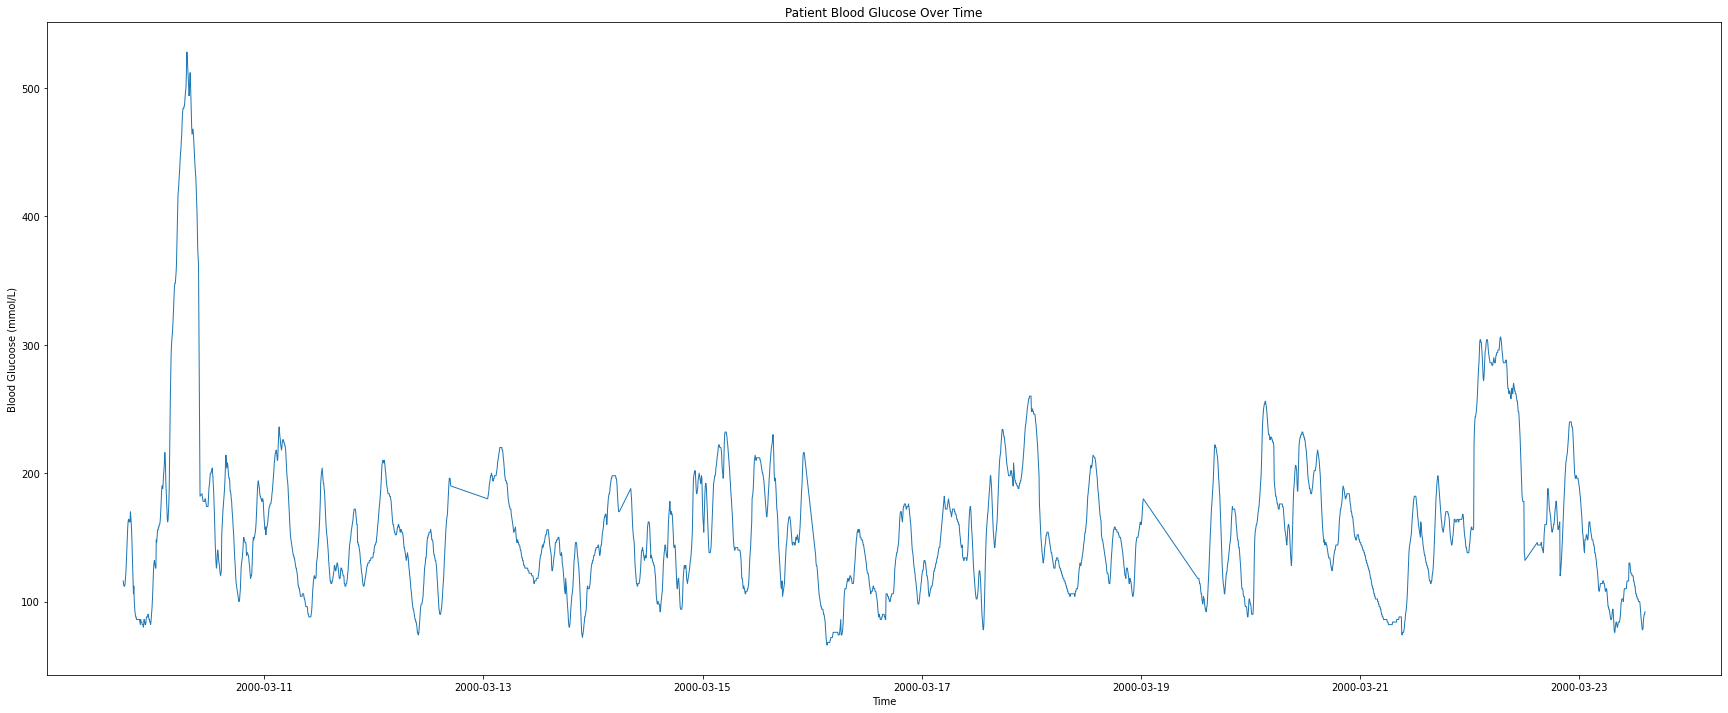

In [4]:
# Display static graphs
%matplotlib inline

# Get each patient
pts = dict()
for ptID in df['ptID'].unique():
  this_df = df[df['ptID'] == ptID]

  # Get only data related to time and glucose_lvl
  this_df = this_df[['time', 'glucose_lvl']]

  # Convert time back into dateime format
  this_df['time']= pd.to_datetime(this_df['time'])

  # Make sure time is in order
  this_df = this_df.sort_values('time')

  # Add patient to dictionary
  pts[ptID] = this_df

# Plot each patient on the same graph
fig, ax = plt.subplots(figsize=(30, 12))
ax.plot(pts[321]['time'], pts[321]['glucose_lvl'], LineWidth=1)
ax.set_title('Patient Blood Glucose Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Blood Glucoose (mmol/L)')

In [5]:
# Create list of individual DataFrames
df = pd.DataFrame()
for pt in pts.keys():

  # Format DataFrame
  this_df = pts[pt]
  this_df['pt'] = pt

  # Add to total DataFrame
  if (df.empty):
    df = this_df
  else:
    df = pd.concat([df, this_df], axis=0)

In [6]:
# Create models dictionary for saving tested models
models = dict()
predictions = dict()

In [7]:
# Split train and test
def splitXandY(df, test_prop=0.2):

  # Create train-test split
  df_test_pts = r.choices(df['pt'].unique(), k=int(test_prop*len(df['pt'].unique())))
  df_train_pts = list(filter(lambda x : x not in df_test_pts, df['pt'].unique()))
  df_test = df.loc[df['pt'].isin(df_test_pts)]
  df_train = df.loc[df['pt'].isin(df_train_pts)]

  # Return split
  return [df_train, df_test]

In [8]:
# Prepare the data
df_train, df_test = splitXandY(df)
minMax = MinMaxScaler(feature_range=(-1, 1))
df_train = df_train.drop(columns=['time', 'pt'])
df_test = df_test.drop(columns=['time', 'pt'])

### **Part 2:** Try Different Training Iterations

In [13]:
# Convert into 3D shape with window size preview
window = 20 # Tuned selection
delay = 6 # Tuned selection
X = []
y = []
y_unf = df_train['glucose_lvl'].to_list()
j = 0
for i in range(window, len(df_train)-delay):
  X.append(df_train.iloc[(i-window):i])
  y.append([y_unf[i+delay]])
X = np.array(X)
y = np.array(y)

In [14]:
# Convert into 3D shape with window size preview
X_test = []
y_test = []
y_unf = df_test['glucose_lvl'].to_list()
j = 0
for i in range(window, len(df_test)-delay):
  X_test.append(df_test.iloc[(i-window):i])
  y_test.append(y_unf[i+delay])
X_test = np.array(X)
y_test = np.array(y)

In [15]:
# Initialize model
model_i = keras.models.Sequential()

# Add layers (Tuned selection)
model_i.add(keras.layers.LSTM(units=25, return_sequences=True,
                            input_shape=(X.shape[1], X.shape[2])))
model_i.add(keras.layers.Dense(10, activation='relu'))
model_i.add(keras.layers.Dropout(0.2))
model_i.add(keras.layers.GRU(units=10, return_sequences=True))
model_i.add(keras.layers.Dense(5, activation='relu'))
model_i.add(keras.layers.Dropout(0.2))
model_i.add(keras.layers.Flatten())
model_i.add(keras.layers.Dense(1, activation='linear'))

# Compile model with optimizer and loss function
model_i.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

# Allow for early exit
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1,
                                   patience=10)

model_i.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20, 25)            2700      
                                                                 
 dense_3 (Dense)             (None, 20, 10)            260       
                                                                 
 dropout_2 (Dropout)         (None, 20, 10)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 10)            660       
                                                                 
 dense_4 (Dense)             (None, 20, 5)             55        
                                                                 
 dropout_3 (Dropout)         (None, 20, 5)             0         
                                                                 
 flatten_1 (Flatten)         (None, 100)              

In [17]:
# Only go through training iteration (because loss can be extracted)

# Train model (Tuned selection)
model = keras.models.clone_model(model_i)
model.compile(optimizer='adam', # Tuned selection
            loss='mean_squared_error',
            metrics=['mean_squared_error'])
m = model.fit(X, y, epochs=30, batch_size=500, callbacks=[es],
              use_multiprocessing=True)

# Get prediction
y_pred = m.model.predict(X_test)

# Models
models[f'Final Model'] = m
predictions[f'Final Model'] = y_pred

Epoch 1/30
1285/1285 [==============================] - 13s 8ms/step - loss: 6804.4971 - mean_squared_error: 6804.4971
Epoch 2/30
1285/1285 [==============================] - 10s 7ms/step - loss: 1786.5598 - mean_squared_error: 1786.5598
Epoch 3/30
1285/1285 [==============================] - 10s 7ms/step - loss: 1570.1986 - mean_squared_error: 1570.1986
Epoch 4/30
1285/1285 [==============================] - 10s 7ms/step - loss: 1484.4803 - mean_squared_error: 1484.4803
Epoch 5/30
1285/1285 [==============================] - 10s 7ms/step - loss: 1446.8466 - mean_squared_error: 1446.8466
Epoch 6/30
1285/1285 [==============================] - 10s 7ms/step - loss: 1438.1373 - mean_squared_error: 1438.1373
Epoch 7/30
1285/1285 [==============================] - 10s 7ms/step - loss: 1419.5441 - mean_squared_error: 1419.5441
Epoch 8/30
1285/1285 [==============================] - 10s 7ms/step - loss: 1407.8671 - mean_squared_error: 1407.8671
Epoch 9/30
1285/1285 [==========================

### **Part 3:** Visualize Results

Text(0, 0.5, 'Mean Squared Error')

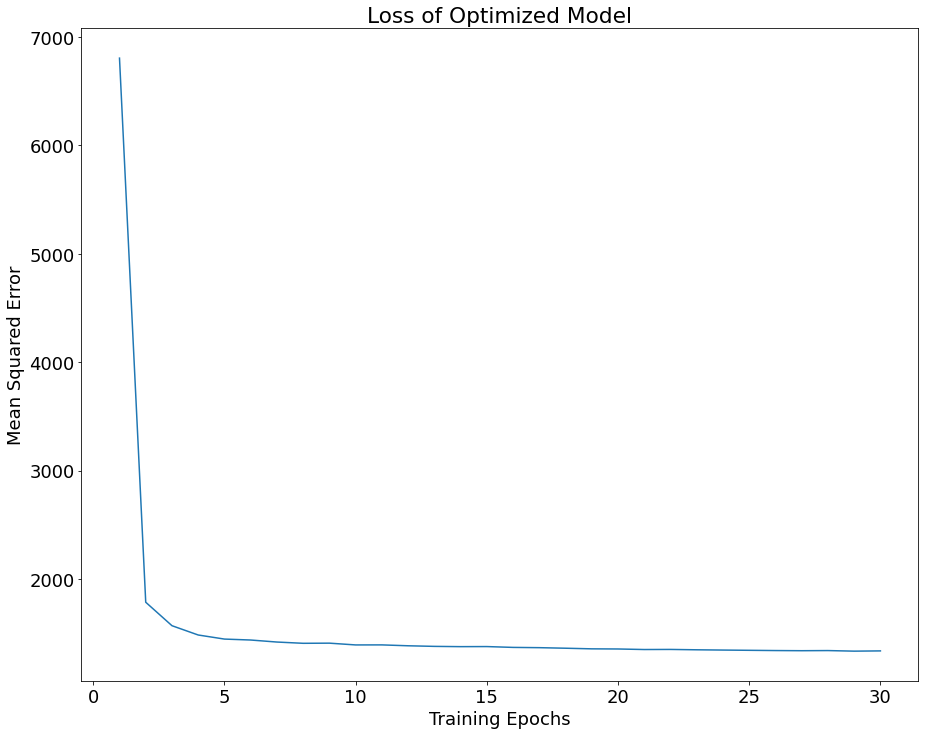

In [21]:
# Get loss over time
model = models['Final Model']
loss = []
loss_list = model.history['loss']
loss_int = len(loss_list) // 30
for i in range(loss_int - 1, len(loss_list), loss_int):
  loss.append(loss_list[i])

# Get epochs
epochs = list(range(1, 31))

# Plot loss/time against training epoch
fig, ax = plt.subplots(figsize=(15, 12))

# Plot these values
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
ax.plot(epochs, loss)

# Add in plot features
ax.set_title('Loss of Optimized Model')
ax.set_xlabel('Training Epochs')
ax.set_ylabel('Mean Squared Error')

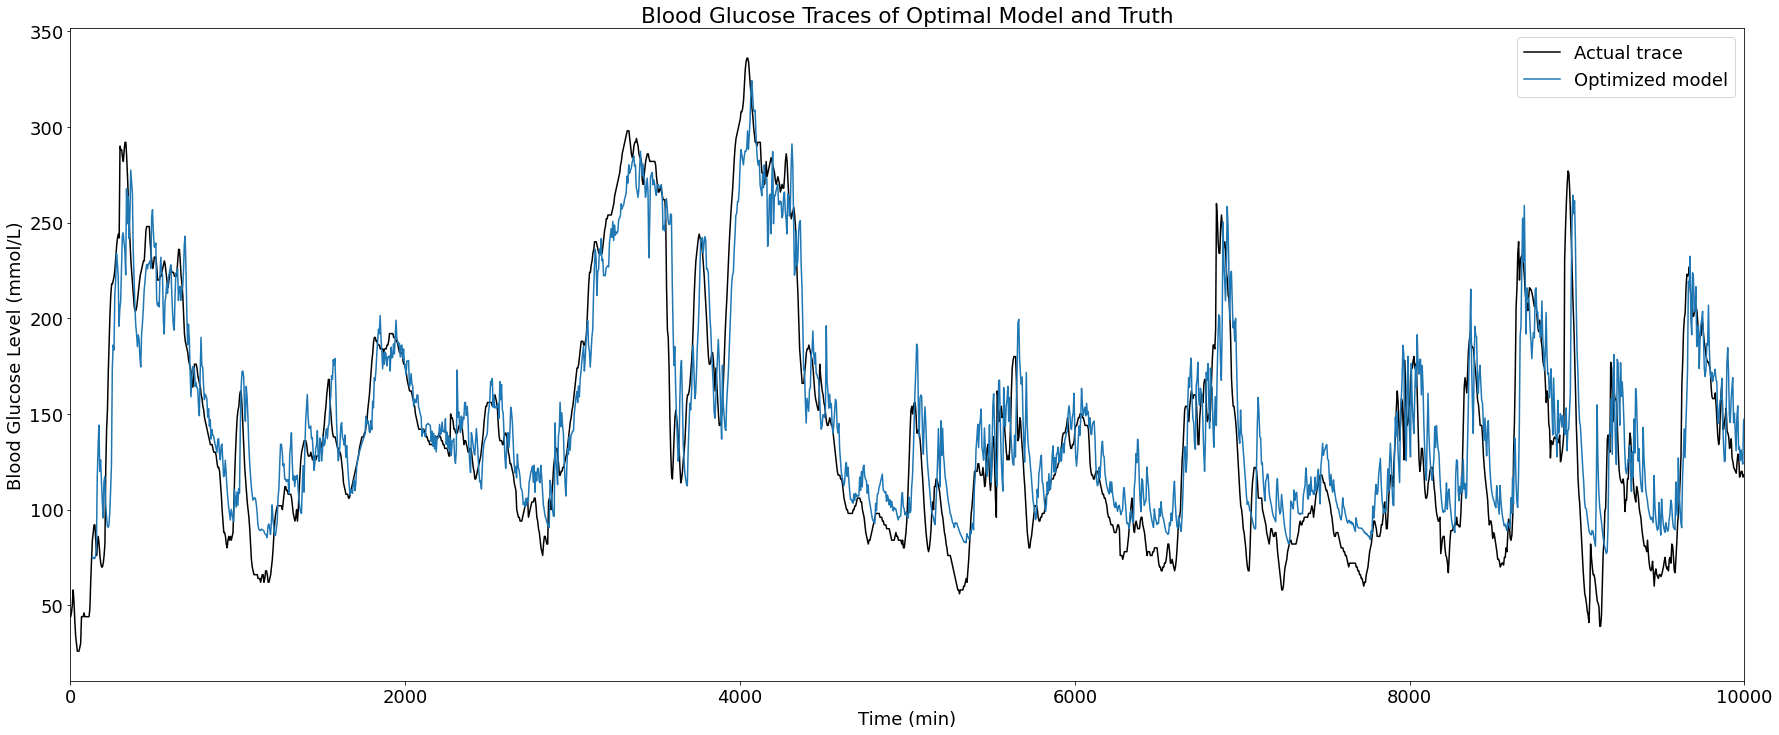

In [41]:
# Get comparison of actual values to training model

# Plot actual traces as proof of concept
fig, ax = plt.subplots(figsize=(30, 12))

# Plot different predictions on the same graph
time_values_1 = list(range(1, 10001, 5))
time_values_2 = list(range(130, 10001, 5))
ax.plot(time_values_1, y_test[0:2000], color='black', label='Actual trace')
prediction = predictions[f'Final Model']
ax.plot(time_values_2, prediction[25:2000], label=f'Optimized model')

# Add labels
ax.set_ylabel('Blood Glucose Level (mmol/L)')
ax.set_xlabel('Time (min)')
ax.set_title('Blood Glucose Traces of Optimal Model and Truth')
ax.set_xlim([0, 10000])
ax.legend()

### **Part 4:** Save Model

In [42]:
# Prepare models
i = 1
for key in models.keys():
  model = models[key]
  model.model.save(f'optimum_model')
  i += 1

In [43]:
# Copy to drive
drive.mount('/content/drive')
!cp -r optimum_model/ "/content/drive/My Drive/"

Mounted at /content/drive
